In [1]:
#%% IMPORTS OF PACKAGES

import mne
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import glob
plt.ion() #toggle interactive plotting
# import numpy as np

In [2]:
data_path = "/work/MEG_data"
ID = "0147"
date_stamp = "20240926_000000"
sess = "A"

log_path = join(data_path, 'logfiles')

meg_path = join(data_path, ID, date_stamp, "MEG/001.sessA/files")
subjects_dir = "/work/freesurfer/"
raw_name = "sess" + sess + ".fif"

In [3]:
#%% READ RAW AND PLOT

raw = mne.io.read_raw_fif(join(meg_path, raw_name), preload=True)
#raw.plot() ## what happens after 10 seconds?
#raw.compute_psd(n_jobs=-1).plot()
#raw.compute_psd(n_jobs=-1, tmax=9).plot()

Opening raw data file /work/MEG_data/0147/20240926_000000/MEG/001.sessA/files/sessA.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 1090000 ... 1784999 =   1090.000 ...  1784.999 secs
Ready.
Reading 0 ... 694999  =      0.000 ...   694.999 secs...


/tmp/ipykernel_1789/1593384855.py:3: RuntimeWarning: This filename (/work/MEG_data/0147/20240926_000000/MEG/001.sessA/files/sessA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(join(meg_path, raw_name), preload=True)


In [4]:
raw.filter(l_freq=None, h_freq=40, n_jobs=-1) # alters raw in-place
#raw.compute_psd(n_jobs=-1).plot()
#raw.plot()

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    8.2s finished


<Raw | sessA.fif, 323 x 695000 (695.0 s), ~1.68 GB, data loaded>

In [5]:
#%% FIND EVENTS

# events = mne.find_events(raw)#, min_duration=0.002) ## returns a numpy array
events = mne.find_events(raw, min_duration=0.002,consecutive=True) ## returns a numpy array

#mne.viz.plot_events(events, sfreq=raw.info['sfreq']) ## 

2010 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15  16 110 120 126 130 134 140 156 210
 211 220 221 230 231 238 239 240 241 243 246 247 252 254 255]


In [6]:
trigger_vals = [1,2,3,4,110,120,130,140,210,211,220,221,230,231,240,241]
true_events = events[np.isin(events[:,2], trigger_vals),:]

In [7]:
event_id = {'Visual/Deck/One': 1, # Decks presented, deck 1 marked
            'Visual/Deck/Two': 2, # Deck 2 marked
            'Visual/Deck/Three': 3, # Deck 3 marked
            'Visual/Deck/Four': 4, # Deck 4 marked
            'Visual/Win/One': 210, # Win screen, deck 1
            'Visual/Win/Two': 220, # Win screen, deck 2
            'Visual/Win/Three': 230, # Win screen, deck 3
            'Visual/Win/Four': 240, # Win screen, deck 4
            'Visual/Loss/One': 211, # Loss screen, deck 1
            'Visual/Loss/Two': 221, # Loss screen, deck 2
            'Visual/Loss/Three': 231, # Loss screen, deck 3
            'Visual/Loss/Four': 241, # Loss screen, deck 4
            #'Response/Switch/First': 11, # y button press (switch), first
            #'Response/Switch/Second': 12, # y button press, second
            #'Response/Switch/Third': 13, # y button press, third
            #'Response/Switch/Fourth': 14, # y button press, fourth
            'Response/Select/One': 110, # b button press (select), deck 1
            'Response/Select/Two': 120, # b button press, deck 2
            'Response/Select/Three': 130, # b button press, deck 3
            'Response/Select/Four': 140, # b button press, deck 4
              }  

In [8]:
repeat_idx = np.where(np.diff(true_events[:,2])==0)[0]
repeat_idx2 = repeat_idx+1 # we need the index of both the first and the second value in those pairs (it's only the second of the two that we delete)
repeat_combined = [[i, j] for i, j in zip(repeat_idx, repeat_idx2)] # we group indices in pairs for printing

# print to inspect if needed
#print(cropped_events[repeat_combined, 2])
#print(cropped_events[repeat_combined, :])

cropped_events = np.delete(true_events, repeat_idx2, axis=0)

In [9]:
print(len(events))
print(len(cropped_events))

2010
468


In [10]:
print(len(cropped_events[cropped_events[:,2]<10,2]))
print(len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]))
print(len(cropped_events[(cropped_events[:,2]>200) & (cropped_events[:,2]<250), 2]))

160
153
155


In [11]:
# loading in the logfiles

log_files = glob.glob(join(log_path, str(int(ID)) + sess + '*'))

df_load = []
for lf in np.sort(log_files):
    print(lf)
    df_load.append(pd.read_csv(join(log_path, lf)))
                        
df = pd.concat(df_load)

/work/MEG_data/logfiles/147A_sess_1 (2024-09-26 10-57-59).csv
/work/MEG_data/logfiles/147A_sess_2 (2024-09-26 11-01-09).csv
/work/MEG_data/logfiles/147A_sess_3 (2024-09-26 11-03-55).csv
/work/MEG_data/logfiles/147A_sess_4 (2024-09-26 11-06-38).csv


In [12]:
# cleaning the concatenated logfiles a bit

df_cropped = df.drop(['ID', 'dur_measured_decks', 'offset_decks', 'exp_type', 'offset_win'], axis=1) # throwing out columns with all NaN
df_cropped['deck_marked'] = df_cropped['init_mark'] + 1 # adjusting the indexing of "init_mark" to reflect actual deck-number rather than python index


In [13]:
# Any mismatches?
df_cropped[['deck_marked']].T.to_numpy()[0]-cropped_events[cropped_events[:,2]<10,2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [14]:
# If you inspect these, you'll see that there was a button press trigger sent before each of these 13 triggers, 
# which for some reason messed up the reading of the trigger (to be 1 higher than it really was)
# So let's replace the deck-trigger-labels with the ones from the logfile
deck_events_idx = np.where(cropped_events[:,2]<10)[0] # what are the indices of these deck events in the cropped_events array?
print(deck_events_idx)
cropped_events[deck_events_idx, 2] = df_cropped['deck_marked']

[  0   3   6   9  11  14  17  20  23  26  29  32  35  38  41  44  46  49
  52  55  58  61  64  67  70  73  76  79  82  85  88  91  94  97 100 103
 106 109 112 115 117 120 123 126 129 132 135 138 141 144 147 150 153 156
 159 162 165 168 171 174 177 180 183 186 189 192 195 198 200 203 206 208
 211 214 217 220 223 226 229 232 235 238 241 244 247 250 253 256 259 262
 265 268 271 274 277 280 283 286 289 291 294 297 300 303 306 309 312 314
 315 318 321 324 327 330 333 336 338 341 344 347 350 353 356 359 362 365
 368 371 374 377 380 383 386 389 392 394 397 400 403 406 409 411 414 417
 420 423 426 429 432 435 438 441 444 447 450 453 456 459 462 465]


In [15]:
# fixing the deck selection labels that might be missing
#print(df_cropped[['deck_select']].T.to_numpy()[0])
deck_select = (cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10)
deck_select_idx = np.where((cropped_events[:,2]>100) & (cropped_events[:,2]<150))[0]
#print(deck_select.astype('int'))

temp_deck_events = np.pad(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10,
                          (0,160-len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10)), 'constant')

#print(df_cropped[['deck_select']].T.to_numpy()[0] - temp_deck_events.astype('int'))
#print(df_cropped[['deck_select']].T.to_numpy()[0] - deck_select[:160].astype('int'))

print(deck_select_idx)

[  1   4   7  12  15  18  21  24  27  30  33  36  39  42  45  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 118 121 124 127 130 133 136 139 142 145 148 151 154 157 160
 163 166 169 172 175 178 181 184 187 190 193 196 201 204 209 212 215 218
 221 224 227 230 233 236 239 242 245 248 251 254 257 260 263 266 269 272
 275 278 281 284 287 292 295 298 301 304 307 310 316 319 322 325 328 331
 334 337 339 342 345 348 351 354 357 360 363 366 369 372 375 378 381 384
 387 390 395 398 401 404 407 410 412 415 418 421 424 427 430 433 436 439
 442 445 448 451 454 457 460 463 466]


In [17]:
# longer epoching for proper ERF analysis
#reject = dict(mag=4e-12, grad=4000e-13, eog=250e-6) # T, T/m, V
reject = None
#Create the epochs
epochs = mne.Epochs(
    raw,
    cropped_events,
    event_id,
    on_missing='warn',   #only report on missing events in data, but continue script
    tmin=-0.200,
    tmax=1.000,
    baseline=(None, 0),
    reject=reject,
    preload=True,
    proj=False,
)  ## have proj True, if you wanna reject


Not setting metadata
468 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 468 events and 1201 original time points ...
0 bad epochs dropped


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


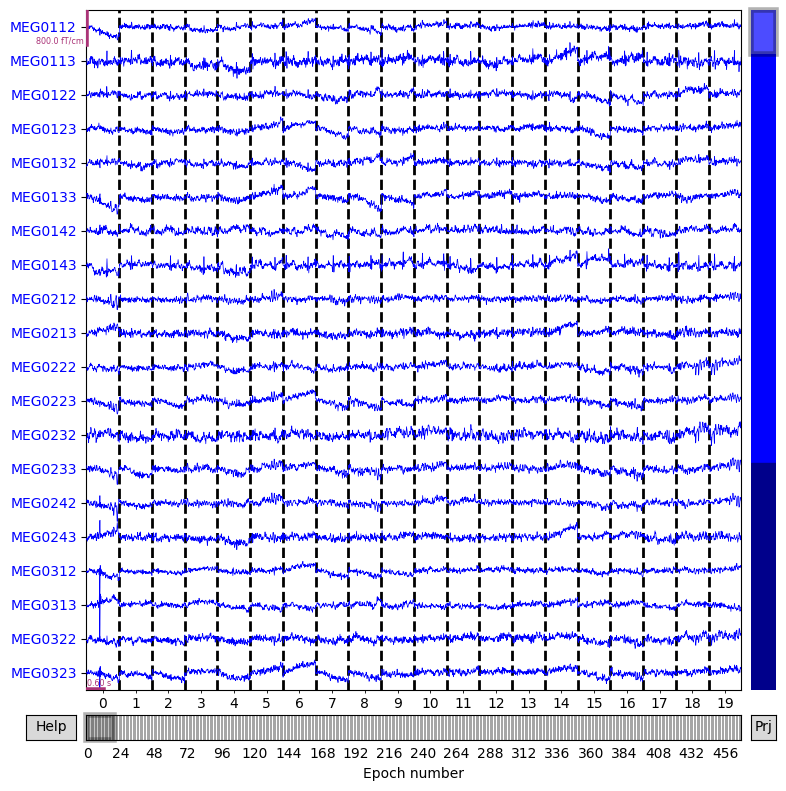

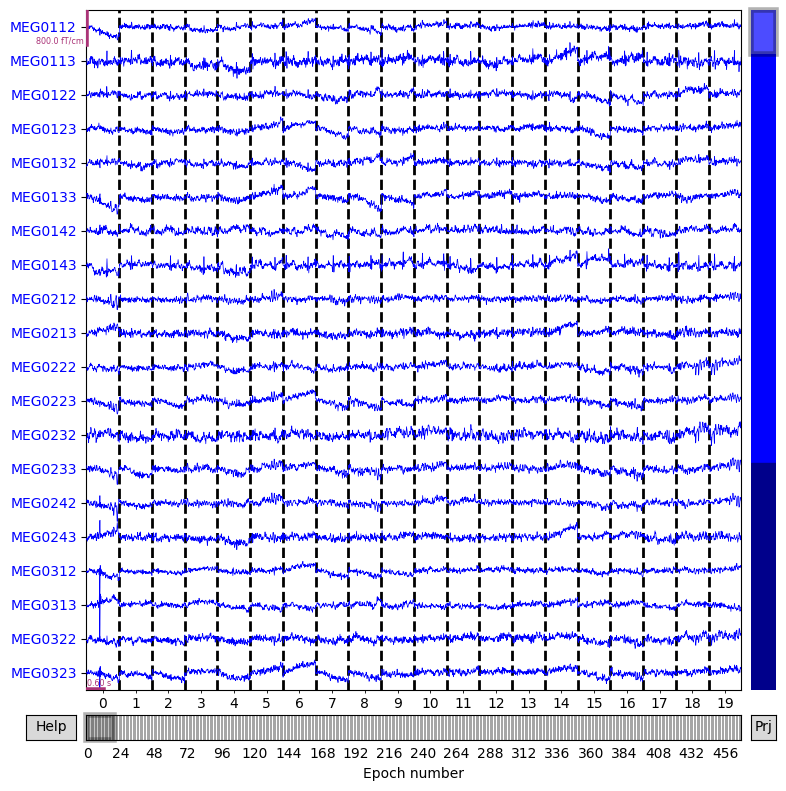

In [18]:
epochs.pick_types(meg=True, eog=False, ias=False, emg=False, misc=False,
                  stim=False, syst=False)

epochs.plot()

In [19]:
# %% EVOKED - AVERAGE - projs not applied

#epochs.set_annotations(annotations, on_missing == "warn")

evokeds = list()
for event in event_id:
    

    evoked = epochs[event].average()
    evokeds.append(evoked)
   # evoked.plot(window_title=evoked.comment)

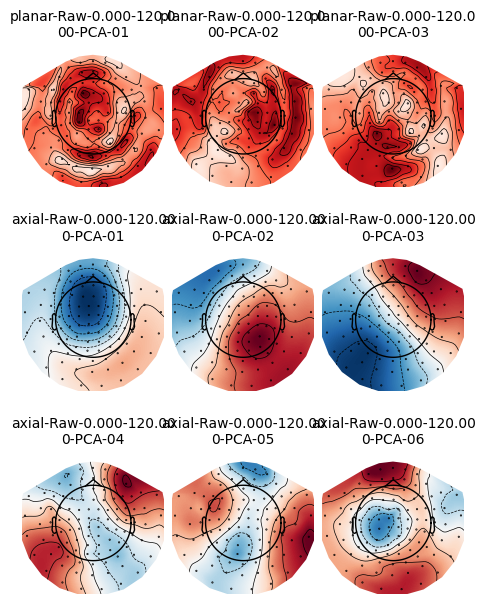

Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...


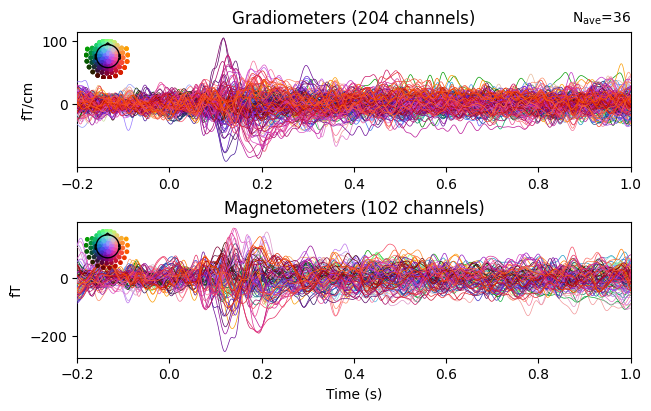

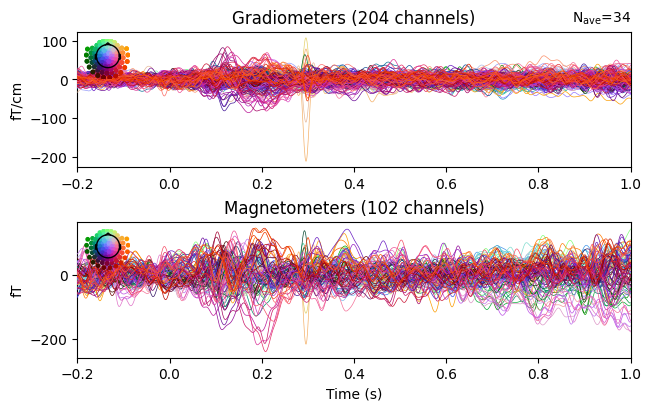

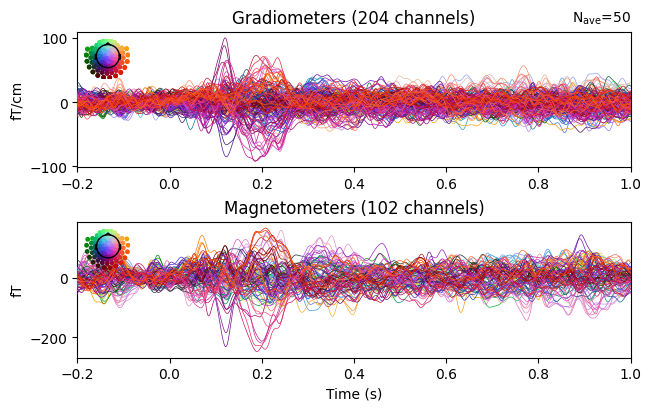

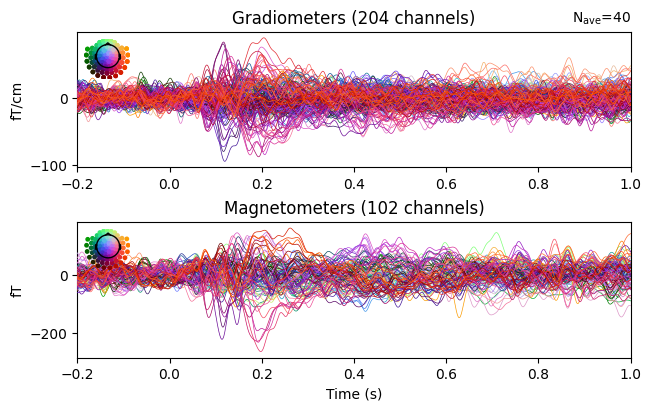

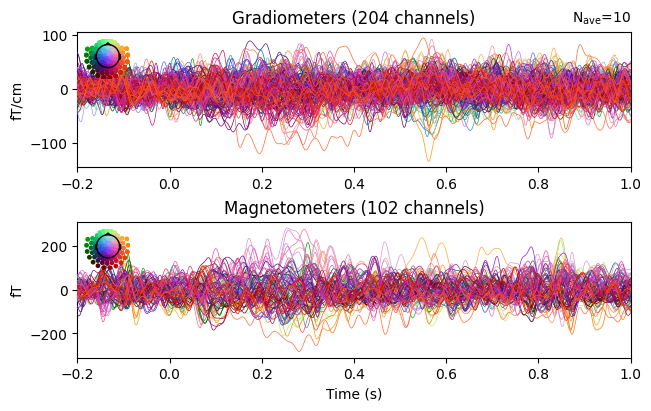

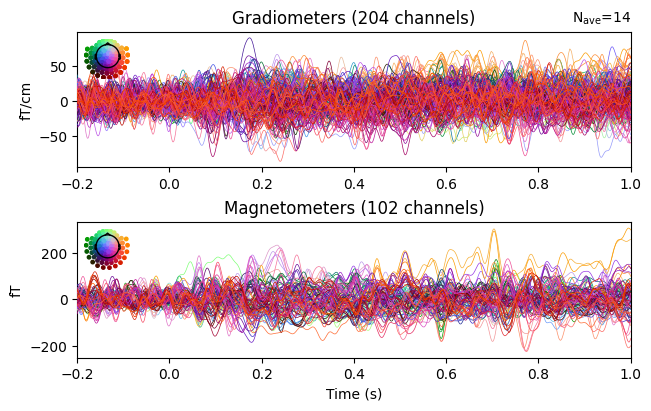

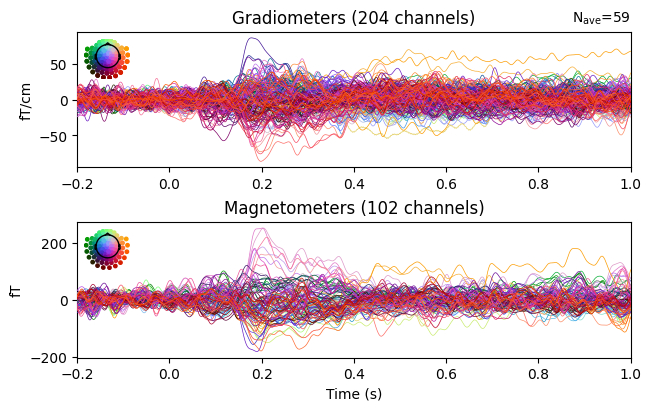

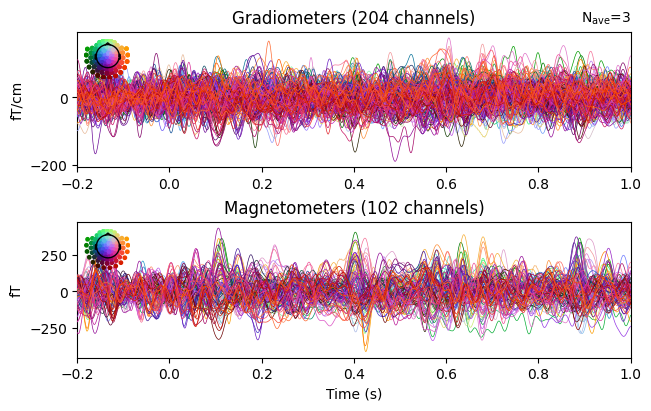

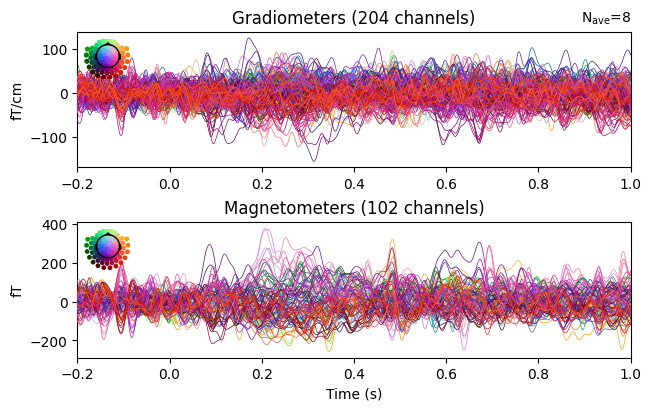

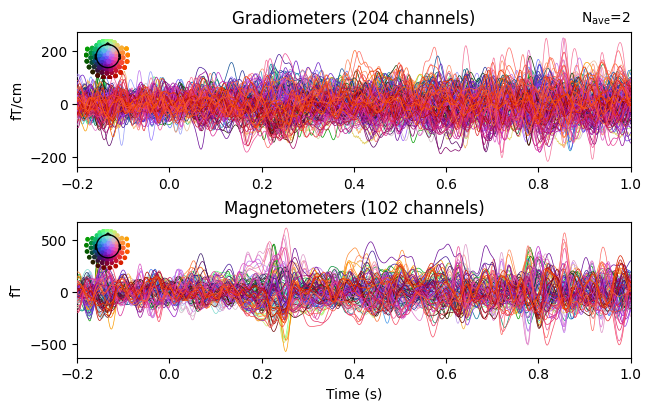

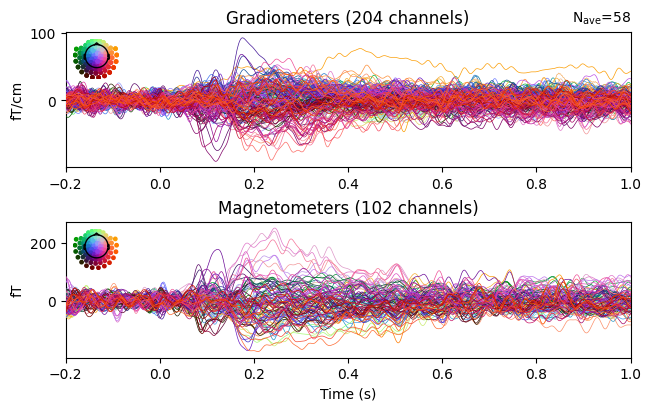

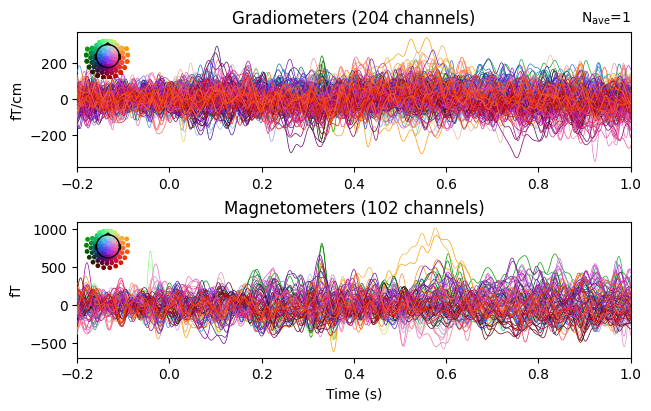

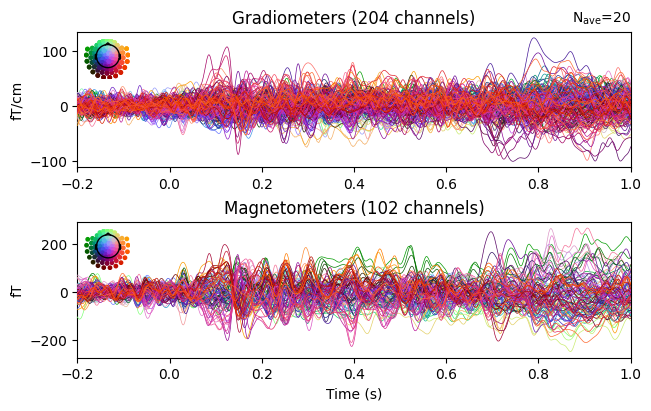

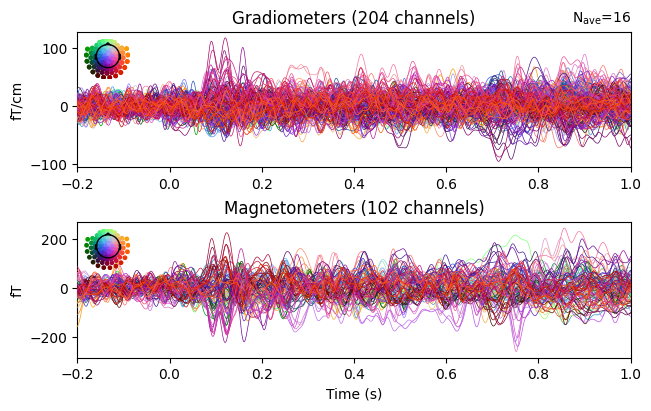

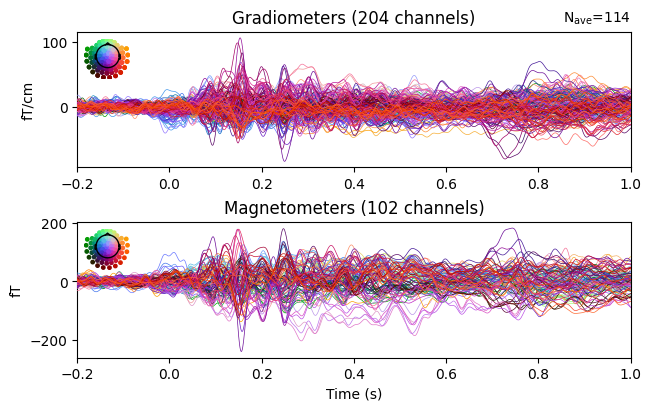

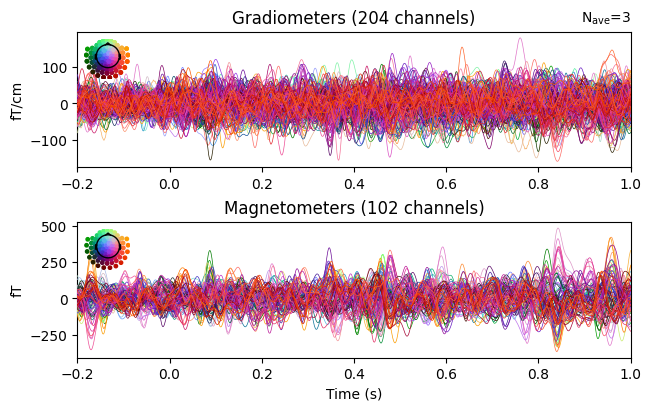

In [20]:
# %% PROJS
mne.viz.plot_projs_topomap(evoked.info["projs"], evoked.info)

epochs.apply_proj()

evokeds = list()
for event in event_id:

    evoked = epochs[event].average()
    evokeds.append(evoked)
    evoked.plot(window_title=evoked.comment)

In [21]:
# %% ARRAY OF INTEREST FOR CLASSIFICATIION
# %% ARRAY OF INTEREST FOR CLASSIFICATIION

X = epochs.get_data()
y = epochs.events[:, 2]   #Choose the last column

times = epochs[0].times # get time points for later

In [22]:
#%% SIMPLE CLASSIFICATION
#Set functions for classification
import numpy as np

def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def equalize_number_of_indices(): # write this yourself
    pass

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        #print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


In [23]:
#%% RUN FUNCTION
#More information about L2 penalty in logistic regression to prevent overfitting: https://www.geeksforgeeks.org/what-is-l2-penalty-in-logistic-regression/
#Classify based on two different trigger events
sensor_vis_win_vs_loss_deck1 = simple_classication(X,
                                  y, triggers=[210, 211],
                                  penalty='l2', C=1e-3)

#sensor_vis_win_vs_loss_deck4 = simple_classication(X,
#                                  y, triggers=[240, 241],
#                                  penalty='l2', C=1e-3) # equalize counts?!

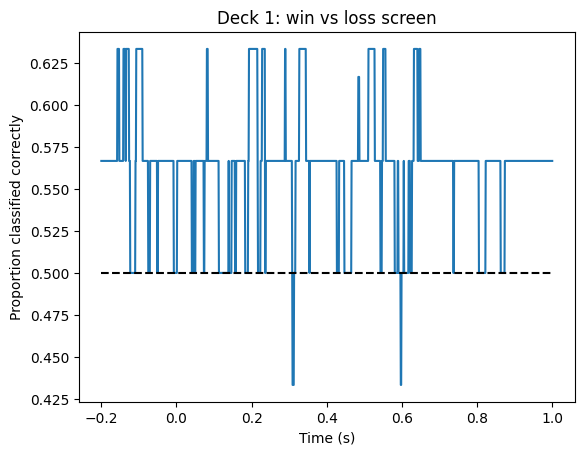

In [24]:
#%% PLOT
plot_classfication(times, sensor_vis_win_vs_loss_deck1,
                   title='Deck 1: win vs loss screen')

#plot_classfication(times, sensor_vis_win_vs_loss_deck4,
#                   title='Deck 4: win vs loss screen')

In [25]:
#%% COLLAPSE EVENTS (if you want to)
#You can assign new values to the triggers, so that you can combine several triggers into a group

def collapse_events(y, new_value, old_values=list()):
    new_y = y.copy()
    for old_value in old_values:
        new_y[new_y == old_value] = new_value
    return new_y

#First, collapse all win events and assign them value 1
y_vis_win_all = collapse_events(y, 1, [210, 220, 230, 240])   #the old values get assigned the new value '1'
#Second, collapse all loss events and assign them value 2
y_vis_win_and_loss_all = collapse_events(y_vis_win_all, 2, [211, 221, 231, 241])  #the old values get assigned the new value '2'

In [26]:
#%% CLASSIFCATION - COLLAPSED EVENTS

sensor_vis_win_loss_all = simple_classication(X,
                                  y_vis_win_and_loss_all, triggers=[1, 2],
                                  penalty='l2', C=1e-3)

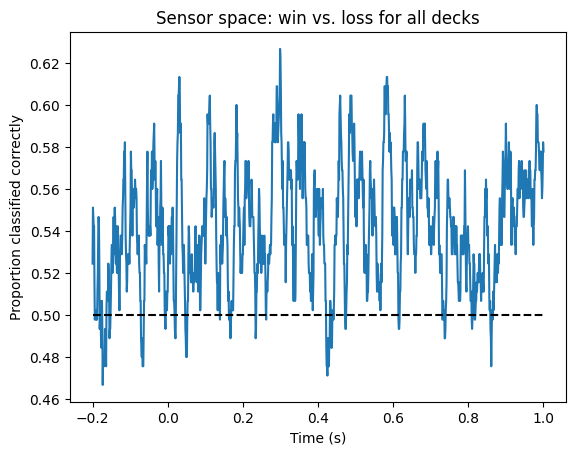

In [27]:
#%% PLOT COLLAPSED

plot_classfication(times, sensor_vis_win_loss_all,
                   title='Sensor space: win vs. loss for all decks')

In [59]:
#First, collapse all win events and assign them value 1
y_choose_averse = collapse_events(y, 1, [110, 130])   #the old values get assigned the new value '1'
#Second, collapse all loss events and assign them value 2
y_choose_averse_ch_s = collapse_events(y_choose_averse, 2, [120, 140])  #the old values get assigned the new value '2'

In [28]:
#%% CLASSIFCATION - COLLAPSED EVENTS

sensor_aveerse = simple_classication(X,
                                  y_choose_averse_ch_s, triggers=[1, 2],
                                  penalty='l2', C=1e-3)

#%% PLOT COLLAPSED

plot_classfication(times, sensor_aveerse,
                   title='Sensor space: choosing a risk averse or seeking deck')

NameError: name 'y_choose_averse_ch_s' is not defined